# Cleaning Data

In [457]:
import re
import numpy
import pandas
import random

### Clean training data

In [458]:
train_path = str("train_dirty.txt")
train_clean_path = str("test_dirty.csv")

dirty_lines = []
clean_lines = []

with open(train_path) as file:
    for line in file.readlines():
        line = re.sub(r"  +", '', line)
        line = re.sub(r"[\n\t]*", '', line)
        dirty_lines.append(line)
        line = line.replace("\"", "\'")
        line = line.replace("<Pros>", "\"")
        line = line.replace("<Cons>", "\"")
        line = line.replace("</Pros>", "\",1")
        line = line.replace("</Cons>", "\",0")
        clean_lines.append(line)

with open(train_clean_path, 'w') as file:
    for line in clean_lines:
        file.write(line + '\n')

### Preview Line Changes

In [459]:
for index in random.sample(range(len(clean_lines)), 3):
    print(dirty_lines[index])
    print(f" => {clean_lines[index]}\n")

<Pros>Fast, sharp printing! Toner keeps going and going...easy to setup/use - attachments available</Pros>
 => "Fast, sharp printing! Toner keeps going and going...easy to setup/use - attachments available",1

<Pros>Inexpensive, plenty of features for the money, good sound quality.</Pros>
 => "Inexpensive, plenty of features for the money, good sound quality.",1

<Pros>Moveable display</Pros>
 => "Moveable display",1



### Clean prediction data

In [460]:
predict_path = str("predict_dirty.txt")
predict_clean_path = str("predict_clean.csv")

dirty_lines = []
clean_lines = []

with open(predict_path, encoding='ISO-8859-1') as file:
    for line in file.readlines():
        line = re.sub(r"  +", '', line)
        line = re.sub(r"[\n\t]*", '', line)
        dirty_lines.append(line)
        line = line.replace("\"", "\'")
        line = line.replace("<Labs>", "\"")
        line = line.replace("</Labs>", "\",?")
        clean_lines.append(line)
        # print(line)

with open(predict_clean_path, 'w') as file:
    for line in clean_lines:
        file.write(line + '\n')

### Preview Line Changes

In [461]:
for index in random.sample(range(len(clean_lines)), 3):
    print(dirty_lines[index])
    print(f" => {clean_lines[index]}\n")

<Labs>Durability(trust me-I have a 2 yr old), Clarity, portability, fast charging time.</Labs>
 => "Durability(trust me-I have a 2 yr old), Clarity, portability, fast charging time.",?

<Labs>Small, great sound quality, long battery life</Labs>
 => "Small, great sound quality, long battery life",?

<Labs>Great buy for the features and picture quality!</Labs>
 => "Great buy for the features and picture quality!",?



# Split Data

### Split into Train, Validation, and Predict Sets

In [462]:
validation_split = 0.65

predictData = pandas.read_csv(predict_clean_path, encoding='unicode_escape')
predictData.columns = ["Text", "Pro/Con"]

inputData = pandas.read_csv(train_clean_path, encoding='unicode_escape')
inputData.columns = ["Text", "Pro/Con"]

trainData = inputData.sample(frac=validation_split)
validationData = inputData.drop(trainData.index)

print("Train & Validation")
print(trainData.shape)
print(validationData.shape)
print("Predictions")
print(predictData.shape)

Train & Validation
(1299, 2)
(700, 2)
Predictions
(43874, 2)


### Separate Text & Labels

In [463]:
train_text = inputData['Text'].values.astype(str)
train_label = inputData['Pro/Con'].values.astype(int)

validation_text = validationData['Text'].values.astype(str)
validation_label = validationData['Pro/Con'].values.astype(int)

predict_text = predictData['Text'].values.astype(str)
predict_label = predictData['Pro/Con'].values.astype(str)

# Tokenize Text

### w/ Tensorflow

In [464]:
import tensorflow as tf
import tensorflow.keras.preprocessing as tfpp

In [465]:
vocab_size = 1024
sequence_length = 64

In [466]:
tokenizer = tfpp.text.Tokenizer(
    num_words=vocab_size,
    oov_token='~misc~',
)
tokenizer.fit_on_texts(train_text)

train_sequences = tokenizer.texts_to_sequences(train_text)
train_padded = tfpp.sequence.pad_sequences(train_sequences, maxlen=sequence_length, truncating='post')

validation_sequences = tokenizer.texts_to_sequences(validation_text)
validation_padded = tfpp.sequence.pad_sequences(validation_sequences, maxlen=sequence_length, truncating='post')

predict_sequences = tokenizer.texts_to_sequences(predict_text)
predict_padded = tfpp.sequence.pad_sequences(predict_sequences, maxlen=sequence_length, truncating='post')

# Learning Model

## Parameters

In [467]:
num_epochs = 250
embedding_dim = 16
learning_rate = 8.5e-5

## Architecture & Training

In [468]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=sequence_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    metrics=[tf.metrics.BinaryAccuracy(name="accuracy")],
)

## Training

In [469]:
history: list = model.fit(
    train_padded,
    train_label,
    batch_size=16,
    epochs=num_epochs,
    validation_data=(validation_padded, validation_label),
).history

Epoch 1/250
125/125 [==============================] - 14s 51ms/step - loss: 0.6930 - accuracy: 0.4907 - val_loss: 0.6923 - val_accuracy: 0.4986
Epoch 2/250
125/125 [==============================] - 5s 36ms/step - loss: 0.6917 - accuracy: 0.4972 - val_loss: 0.6903 - val_accuracy: 0.5043
Epoch 3/250
125/125 [==============================] - 4s 36ms/step - loss: 0.6876 - accuracy: 0.5598 - val_loss: 0.6832 - val_accuracy: 0.5371
Epoch 4/250
125/125 [==============================] - 5s 37ms/step - loss: 0.6761 - accuracy: 0.5668 - val_loss: 0.6648 - val_accuracy: 0.6214
Epoch 5/250
125/125 [==============================] - 5s 37ms/step - loss: 0.6453 - accuracy: 0.6468 - val_loss: 0.6166 - val_accuracy: 0.6643
Epoch 6/250
125/125 [==============================] - 5s 38ms/step - loss: 0.5812 - accuracy: 0.7114 - val_loss: 0.5418 - val_accuracy: 0.8743
Epoch 7/250
125/125 [==============================] - 5s 36ms/step - loss: 0.5149 - accuracy: 0.8099 - val_loss: 0.4827 - val_accuracy

### Save Model

In [470]:
model.save(str(f".\models\model_{num_epochs}e.h5"))

# Evaluation

### Load Model

In [471]:
model = tf.keras.models.load_model(str(f".\models\model_{num_epochs}e.h5"))

### Plot Metrics

<Figure size 432x288 with 0 Axes>

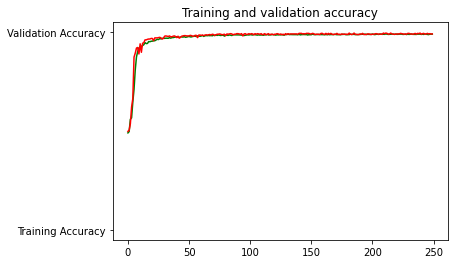

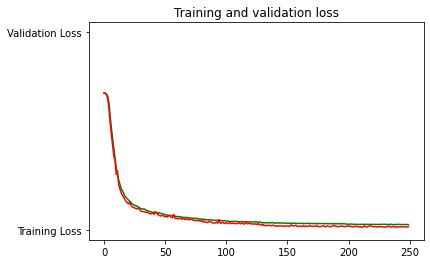

<Figure size 432x288 with 0 Axes>

In [472]:
%matplotlib inline
import matplotlib.pyplot as plt

epochs=range(len(history['accuracy']))

acc = history['accuracy']
val_acc = history['val_accuracy']
plt.plot(epochs, acc, 'g', 'Training Accuracy')
plt.plot(epochs, val_acc, 'r', 'Validation Accuracy')
plt.title('Training and validation accuracy')
plt.figure()

loss = history['loss']
val_loss = history['val_loss']
plt.plot(epochs, loss, 'g', 'Training Loss')
plt.plot(epochs, val_loss, 'r', 'Validation Loss')
plt.title('Training and validation loss')
plt.figure()

# Predictions

### Generate From Model

In [473]:
predictions: numpy.array = model.predict(predict_padded, batch_size=16, verbose=1)
numpy.round(predictions, 3)

2743/2743 [==============================] - 18s 6ms/step


array([[1.   ],
       [1.   ],
       [1.   ],
       ...,
       [0.002],
       [1.   ],
       [0.002]], dtype=float32)

### Classify the predictions into 'Pro or 'Con

In [474]:
classifications = []
for value in predictions:
    if (value > 0.5): classifications.append("Pro")
    else: classifications.append("Con")
classifications = numpy.asarray(classifications)

print(predictions[:6].T)
print(classifications[:6].T)

[[1.         1.         1.         1.         0.00118515 0.00130841]]
['Pro' 'Pro' 'Pro' 'Pro' 'Con' 'Con']


### Save Predictions to File

In [475]:
with open(str(f".\predictions\predictions_{num_epochs}e.csv"), 'w') as output:
    for index in range(len(predict_text)):
        output.write(f"\"{predict_text[index]}\",{classifications[index]}\n")

# Compare Predictions Against Text

### Against Prediction Set

In [476]:
for index in random.sample(range(len(predict_text)), 8):
    print(predict_text[index])
    print(f" => {classifications[index]}")

The screen is not easy to read in direct sunlight.
 => Con
Cheap!, Color Screen, Battery Life, polyphonic ring tones
 => Pro
16MB memory stick is a little bit small 
 => Con
Small, lightweight
 => Pro
Nokia 8310
 => Pro
Cheap, some useful features, phone wraps, good sound quality
 => Pro
Intended functionality.
 => Pro
2.1 mega pixel
 => Con


### Against Ambiguous Text

In [477]:
user_text = [
    "\"Not great, but if you are working on a budget, you can do worse\" |= PRO",
    "\"Absolutely the worst!\" |= CON",
    "\"Broken upon arrival\" |= CON",
    "\"I want to love this, but I can't really recommend\" |= CON",
    "\"Crap product, terrible design, cheap\" |= CON",
    "\"Pickup when on sale, not worth full price\" |= CON",
    "\"Great for amateurs\" |= PRO",
    "\"Recommend only to professionals\" |= CON",
    "\"fantastic for dumpsters\" |= CON",
    "\"Recommend if you have no idea what you are doing\" =| PRO",
    "\"goes right in the dumpster\" |= CON",
    "\"best to avoid this\" |= CON",
    # "\"replace\"",
]

user_sequences = tokenizer.texts_to_sequences(user_text)
user_padded = tfpp.sequence.pad_sequences(user_sequences, maxlen=sequence_length)

user_predictions = model.predict(user_padded, batch_size=1, verbose=1)

user_classifications = []
for value in predictions:
    if (value > 0.5): user_classifications.append("Pro")
    else: user_classifications.append("Con")
user_classifications = numpy.asarray(classifications)

for index in range(len(user_text)):
    print(user_text[index])
    print(f" => {user_classifications[index]}")

12/12 [==============================] - 1s 8ms/step
"Not great, but if you are working on a budget, you can do worse" |= PRO
 => Pro
"Absolutely the worst!" |= CON
 => Pro
"Broken upon arrival" |= CON
 => Pro
"I want to love this, but I can't really recommend" |= CON
 => Pro
"Crap product, terrible design, cheap" |= CON
 => Con
"Pickup when on sale, not worth full price" |= CON
 => Con
"Great for amateurs" |= PRO
 => Pro
"Recommend only to professionals" |= CON
 => Pro
"fantastic for dumpsters" |= CON
 => Pro
"Recommend if you have no idea what you are doing" =| PRO
 => Pro
"goes right in the dumpster" |= CON
 => Con
"best to avoid this" |= CON
 => Pro
